In [12]:
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from time import time

import src.training as training
import src.models as models

from importlib import reload
reload(training)
reload(models)

device = 'cuda'

In [13]:
# Go through the training data and make sure none match the
# LSST distribution

lsst_z0 = 0.16698488
lsst_alpha = 0.6226941

# go through the h5 file and make sure none of the redshifts match the LSST distribution

filepath = 'data/1000tasks_5000samples_44seed.h5'

with h5.File(filepath, 'r') as f:
    dndz_params = f['dndz_params'][:]
    
    for i in range(dndz_params.shape[0]):
        z0, alpha, model = dndz_params[i]
        if model == 1:
            if np.abs(z0 - lsst_z0) < 0.002 and np.abs(alpha - lsst_alpha) < 0.002:
                print('Found LSST model')
                print(z0, alpha)
                print(i)
            else:
                pass
        else:
            pass

Found LSST model
0.16698487934009149 0.6226940989658858
214


In [14]:
seed = 14

batch_size = 5
n_tasks = 20
n_samples = 1000

rng = np.random.default_rng(seed)
task_inds = np.random.choice(1000, n_tasks+1, replace=False)
sample_inds = np.random.choice(5000, n_samples, replace=False)
# sort the indices
task_inds.sort()

# Load the data and construct a dataloader
filepath = 'data/1000tasks_5000samples_14seed.h5'
with h5.File(filepath, 'r') as f:
    X_train = f['X_train'][task_inds]
    y_train = f['y_train'][task_inds]
    X_val = f['X_train'][task_inds[-1]]
    y_val = f['y_train'][task_inds[-1]]

X_train = X_train[:,sample_inds,:]
y_train = y_train[:,sample_inds,:]

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
print(X_train.shape, y_train.shape)

train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

X_val_train, X_val_test, y_val_train, y_val_test = train_test_split(X_val, y_val, train_size=100, test_size=4000, random_state=14)

X_val_train = torch.tensor(X_val_train, dtype=torch.float32).to(device)
y_val_train = torch.tensor(y_val_train, dtype=torch.float32).to(device)
X_val_test = torch.tensor(X_val_test, dtype=torch.float32).to(device)
y_val_test = torch.tensor(y_val_test, dtype=torch.float32).to(device)

# Scale
y_val_train = torch.log(y_val_train)
y_val_test = torch.log(y_val_test)

ScalerX = training.TorchStandardScaler()
ScalerY = training.TorchStandardScaler()

X_val_train = ScalerX.fit_transform(X_val_train)
y_val_train = ScalerY.fit_transform(y_val_train)
X_val_test = ScalerX.transform(X_val_test)
y_val_test = ScalerY.transform(y_val_test)

# Load the model
model = models.FastWeightCNN(
    input_size=10,
    latent_dim=(16,16),
    output_size=750,
    dropout_rate=0.2
)

# Initialise a MetaLearner
metalearner = training.MetaLearner(
    model=model,
    outer_lr=0.01,
    inner_lr=0.001,
    loss_fn=torch.nn.MSELoss,
    beta1=0.9,
    beta2=0.999,
    epsilon=1e-8,
    seed=14,
    device=device
)

# Train the model
converged = False
meta_losses = []
val_losses = []
epoch = 0
best_val_loss = np.inf
strike = 0
force_stop = np.inf
start = time()
while not converged:
    epoch_loss = 0.0  # Accumulate loss for reporting purposes
    batch_count = 0   # Keep track of the number of batches
    metalearner.model.train()
    # Iterate through all batches in the dataloader
    for x_batch, y_batch in train_dataloader:
        x_batch = x_batch.to(metalearner.device)  # Move to GPU if available
        y_batch = y_batch.to(metalearner.device)

        # Take logarithm of y_batch
        y_batch = torch.log(y_batch)

        # Split the data into support and query sets
        x_spt, y_spt, x_qry, y_qry = training.support_query_split(
            x_batch, y_batch, spt_frac=0.6
        )

        # Perform one meta update step across the batch, scaling applied internally
        meta_loss = metalearner.meta_train(
            x_spt, y_spt, x_qry, y_qry, inner_steps=5
        )
        
        # Accumulate meta-loss for epoch statistics
        epoch_loss += meta_loss
        batch_count += 1

    # Compute average meta-loss for the epoch
    avg_meta_loss = epoch_loss / batch_count
    meta_losses.append(avg_meta_loss)
    epoch += 1

    # fine-tune the model on the validation set
    task_weights, _ = metalearner.finetune(X_val_train, y_val_train, adapt_steps=32, use_new_adam=True)

    # Evaluate the model on the test set
    metalearner.model.eval()
    with torch.no_grad():
        y_pred = metalearner.model(X_val_test, params=task_weights)
        new_val_loss = metalearner.loss_fn(y_pred, y_val_test).item()
        val_losses.append(new_val_loss)

    if best_val_loss - new_val_loss < 1e-5:
        strike += 1
        if strike >= 20 or epoch > force_stop:
            converged = True
            print('Validation loss has not improved for 20 epochs. Stopping training.')
    else:
        strike = 0

    # Update the best validation loss if necessary
    if new_val_loss < best_val_loss:
        best_val_loss = new_val_loss

    print(f'Epoch {epoch} - Val Loss: {new_val_loss} - Strike: {strike}')
    print('Took', time()-start, 'seconds')

# Plot the meta-loss over epochs
plt.plot(meta_losses, label='Training meta Loss')
plt.plot(val_losses, label='Validation Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Average Meta Loss')
plt.title('Meta Loss Over Epochs')
plt.legend()

# Save meta weights
# torch.save(
#     metalearner.model.state_dict(),
#     '{}batch_{}samples_{}tasks_metalearner_weights.pt'.format(batch_size, n_samples, n_tasks)
# )

torch.Size([21, 1000, 10]) torch.Size([21, 1000, 750])
Epoch 1 - Val Loss: 0.08584409952163696 - Strike: 0
Took 1.4608595371246338 seconds
Epoch 2 - Val Loss: 0.07205646485090256 - Strike: 0
Took 2.8277335166931152 seconds
Epoch 3 - Val Loss: 0.05456123873591423 - Strike: 0
Took 4.165403127670288 seconds
Epoch 4 - Val Loss: 0.04590390622615814 - Strike: 0
Took 5.4925432205200195 seconds


KeyboardInterrupt: 

In [12]:
# Save meta weights
torch.save(
    metalearner.model.state_dict(),
    '{}batch_{}samples_{}tasks_metalearner_weights.pt'.format(batch_size, n_samples, n_tasks)
)

In [4]:
# Check for existing metalearner class in current namespace
if 'metalearner' in locals():
   pass
else:

    model = models.FastWeightCNN(
        input_size=10,
        latent_dim=(16,16),
        output_size=750,
        dropout_rate=0.2
    )

    # Create a new MetaLearner instance
    metalearner = training.MetaLearner(
        model=model,
        outer_lr=0.01,
        inner_lr=0.001,
        loss_fn=torch.nn.MSELoss,
        beta1=0.9,
        beta2=0.999,
        epsilon=1e-8,
        seed=14,
        device=device
    )

# Load metaleraner weights
metalearner.model.load_state_dict(
    torch.load(
        '{}batch_{}samples_{}tasks_metalearner_weights.pt'.format(batch_size, n_samples, n_tasks)
    )
)

<All keys matched successfully>

In [5]:
filepath = 'mcmc_dndz_nsamples=20000.h5'
with h5.File(filepath, 'r') as f:
    X = f['hypercube'][:]
    y = f['c_ells'][:]

# Take log of y
y_log = np.log(y)

# Split into test training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y_log, train_size=100, random_state=14)

# Send data to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test, dtype=torch.float32).to(device)

#Scale the data
ScalerX = training.TorchStandardScaler()
X_train = ScalerX.fit_transform(X_train)
X_test = ScalerX.transform(X_test)

ScalerY = training.TorchStandardScaler()
y_train = ScalerY.fit_transform(y_train)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
    
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=2048, shuffle=True)

# test on the test set in batches
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=2048, shuffle=False)

X_train shape: torch.Size([100, 10])
y_train shape: torch.Size([100, 750])
X_test shape: torch.Size([19900, 10])
y_test shape: torch.Size([19900, 750])


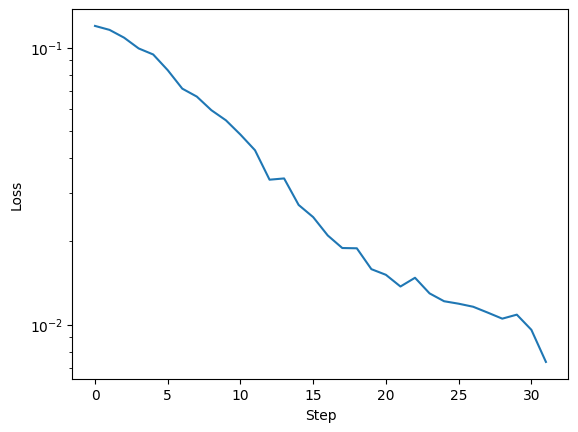

In [6]:
# Perform finetuning
task_weights, losses = metalearner.finetune(X_train, y_train, adapt_steps=32)

plt.plot(losses)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.yscale('log')

Total predictions: torch.Size([19900, 750])
MAML MAPE: 5.5138416
MAML XAPE: 111.22614
MAML Failure Rate: 0.3334673366834171


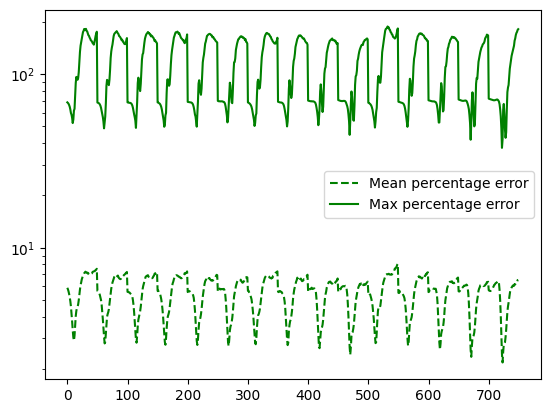

In [7]:
############# MAML TRAINING #############
# Construct empty tensor to store 
metalearner.model.eval()
y_pred = torch.tensor([]).to(device)
for X_batch, y_batch in test_loader:
    model.eval()
    with torch.no_grad(): # don't compute gradients during inference
        y_pred_batch = metalearner.model(X_batch, params=task_weights)
        y_pred = torch.cat((y_pred, y_pred_batch), dim=0)

print('Total predictions:', y_pred.shape)
# Inverse transform the data
y_pred = ScalerY.inverse_transform(y_pred)

y_pred_np = y_pred.cpu().numpy()
y_test_np = y_test.cpu().numpy()

# Exponentiate the data
y_pred_np = np.exp(y_pred_np)
y_test_np = np.exp(y_test_np)

# Compute mean absolute percentage error along the test set
apes = np.abs((y_test_np - y_pred_np) / y_test_np) * 100
ell_ape = np.mean(apes, axis=1)
maml_mape = np.mean(apes, axis=0)
maml_xape = np.max(apes, axis=0)
maml_frate = len(ell_ape[ell_ape > 5]) / len(ell_ape)
plt.plot(maml_mape, c='g', ls='--', label='Mean percentage error')
plt.plot(maml_xape, c='g', ls='-', label='Max percentage error')
plt.yscale('log')
plt.legend()

print('MAML MAPE:', np.mean(maml_mape))
print('MAML XAPE:', np.mean(maml_xape))
print('MAML Failure Rate:', maml_frate)

### Extract activations from network layers

In [22]:
# Collect acitvations to plot feature maps
activations = {}

# Define a hook function to collect activations
def hook_fn(module, input, output):
    activations.append(output)

# Register the hook
for i, layer in enumerate(metalearner.model.children()):
    if isinstance(layer, torch.nn.Conv2d):
        layer.register_forward_hook(hook_fn)
        print(f"Hook registered to layer {i}: {layer}")

# Pull a single task from the test dataloader
x_batch, y_batch = next(iter(test_dataloader))
x_batch = x_batch.to(metalearner.device)
y_batch = y_batch.to(metalearner.device)

# Take logarithm of y_batch
y_batch = torch.log(y_batch)

# Split the data into support and query sets
x_spt, y_spt, x_qry, y_qry = training.support_query_split(
    x_batch, y_batch, n_spt=400
)

# Remove batch dimension
x_spt = x_spt.squeeze(0)
y_spt = y_spt.squeeze(0)
x_qry = x_qry.squeeze(0)
y_qry = y_qry.squeeze(0)

# Scale the data
ScalerX = training.TorchStandardScaler()
x_spt = ScalerX.fit_transform(x_spt)
x_qry = ScalerX.transform(x_qry)

ScalerY = training.TorchStandardScaler()
y_spt = ScalerY.fit_transform(y_spt)

# Finetune the model on the support set
task_weights = metalearner.finetune(x_spt, y_spt, adapt_steps=128)

Hook registered to layer 1: Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Hook registered to layer 2: Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
Hook registered to layer 3: Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4), dilation=(4, 4))


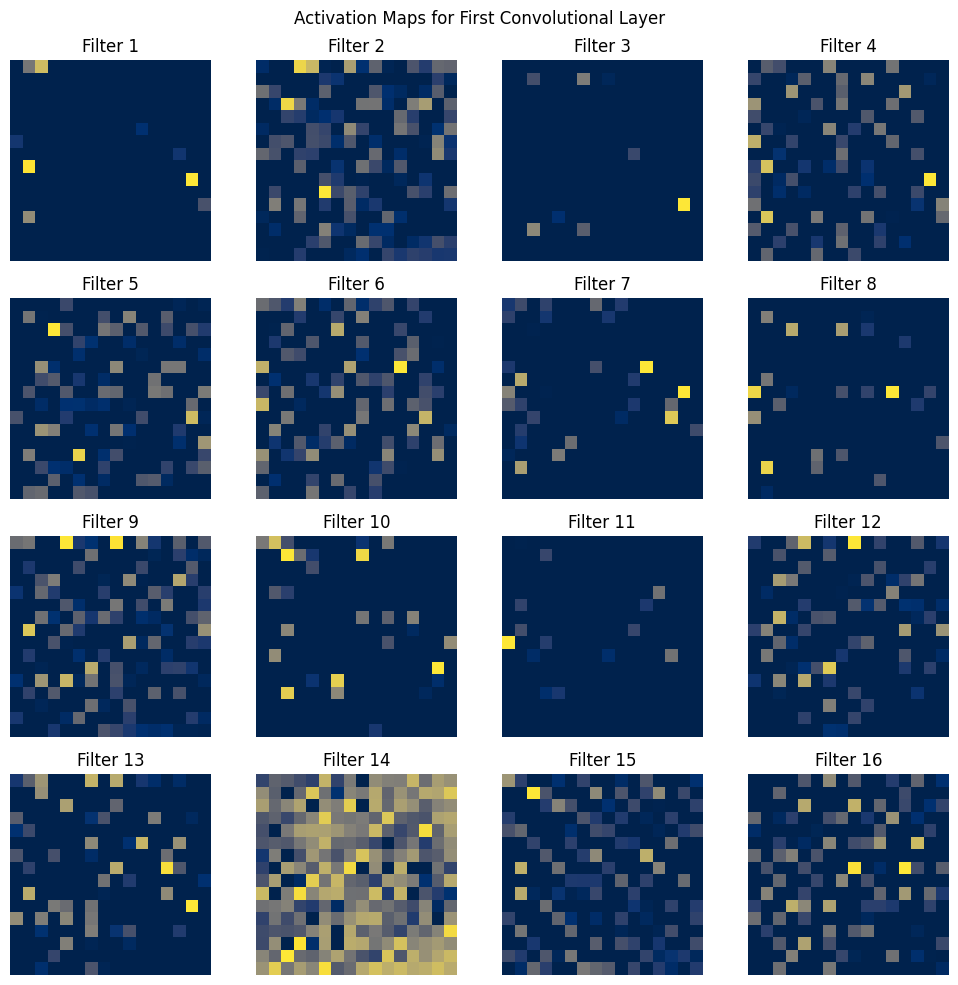

In [6]:
# perform forward pass to collect activations
metalearner.model.eval()

# Perform a forward pass
with torch.no_grad():
    _ = metalearner.model(x_qry[0], task_weights, activations=activations)

activation = activations['conv1']

# Assuming `activation` is the output of the first convolutional layer, with shape (batch_size, 16, 16, 16)
# If you have a batch dimension, e.g., (batch_size, 16, 16, 16), select the first item
activation = activation[0]  # Remove batch dimension if needed

# Set up a grid plot with 4 rows and 4 columns (for 16 feature maps)
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("Activation Maps for First Convolutional Layer")

for i in range(16):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    ax.imshow(activation[i].cpu().detach().numpy(), cmap='cividis')
    ax.axis('off')
    ax.set_title(f"Filter {i+1}")

plt.tight_layout()
plt.show()

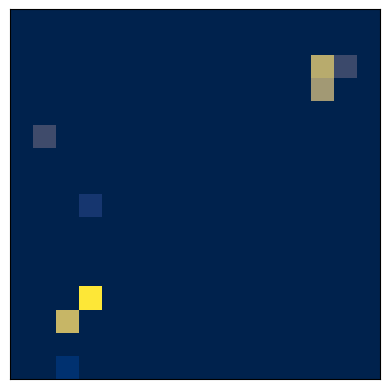

In [7]:
# Run a forward pass and capture activations for each layer
activations = {}
with torch.no_grad():
    _ = metalearner.model(x_qry, params=task_weights, activations=activations)

# Save or plot a few feature maps only for convolutional layers
for layer_name, activation in activations.items():
    # Check if the layer is a convolutional layer by its name
    if "conv" in layer_name:
        for i in range(activation.shape[1]):  # Show only a few filters
            plt.imshow(activation[0, i].cpu().detach().numpy(), cmap='cividis')
            plt.xticks([])
            plt.yticks([])
            plt.savefig(f"activation_plots/{layer_name}_filter_{i}.png", bbox_inches='tight', pad_inches=0)